In [25]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, ifft
from math import floor
from os import listdir
from os.path import isfile, join
import json
import matplotlib
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.rcParams['figure.figsize'] = [6.4, 4.8]

## Testing data

In [26]:
data_base_dir = "/home/geosearchef/csi/csi-repo/data/"

In [27]:
csi_dir_breathing_fast = join(data_base_dir, "csi-2020-08-20/csi-breathingFast_2020-08-20_18:28:07/")
csi_dir_breathing_slow = join(data_base_dir, "csi-2020-08-20/csi-breathingSlow_2020-08-20_18:26:49/")
csi_dir_breathing_weak = join(data_base_dir, "csi-2020-08-20/csi-breathingWeak_2020-08-20_18:27:27/")
csi_dir_breathing_direct_strong = join(data_base_dir, "csi-2020-08-21/csi-breathingDirectReflectStronger_2020-08-21_15:22:35")
csi_dir_breathing_direct_very_weak = join(data_base_dir, "csi-2020-08-21/csi-breathingDirectReflectVeryWeak_2020-08-21_15:20:44")
csi_dir_breathing_periodic_movement = join(data_base_dir, "csi-2020-08-21/csi-rockingBackAndForth_2020-08-21_15:24:47")

ecg_first_test_data = join(data_base_dir, "ecg-recording_2020-11-21_19:39:33/")
ecg_500hz_chest = join(data_base_dir, "ecg-2020-12-08/ecg-500hz-chest_2020-12-08_20:03:12/")
ecg_armfoot = join(data_base_dir, "ecg-2020-12-08/ecg-qrs-armfoot_2020-12-08_19:20:37/")
ecg_armfoot_nosupply = join(data_base_dir, "ecg-2020-12-08/ecg-armfoot_nosupply_2020-12-08_19:33:10/") # without powersupply
ecg_500hz_armfoot_nosupply = join(data_base_dir, "ecg-2020-12-08/ecg-500hz-armfoot-distancefromgrid_2020-12-08_19:48:23/")

esp_test_resp_data = join(data_base_dir, "esp_csi_test/esp_resp_sensitive_scenario/")
esp_test_hr_data = join(data_base_dir, "esp_csi_test/esp_hr_sensitive_scenario/")

## Scenario data
Contains CSI and ECG data for
 - different TX antennas (directional / omnidirectional)
 - different locations (in LOS, near LOS and behind LOS)
 - different distances (2m and 4m)

In [28]:
scenario_2m_dir_nearpath = join(data_base_dir, "both-2020-12-15/both-2m-dir-nearpath_2020-12-15_20:06:28_2020-12-15_20:10:41/")
scenario_2m_dir_inpath = join(data_base_dir, "both-2020-12-15/both-2m-dir-inpath_2020-12-15_20:06:28_2020-12-15_20:08:21/")
scenario_2m_dir_behindpath = join(data_base_dir, "both-2020-12-15/both-2m-dir-behindpath_2020-12-15_20:06:28/")
scenario_2m_omni_nearpath = join(data_base_dir, "both-2020-12-15/both-2m-omni-nearpath_2020-12-15_20:02:42/")
scenario_2m_omni_inpath = join(data_base_dir, "both-2020-12-15/both-2m-omni-inpath_2020-12-15_20:01:39/")
scenario_2m_omni_behindpath = join(data_base_dir, "both-2020-12-15/both-2m-omni-behindpath_2020-12-15_20:04:03/")

scenario_4m_omni_nearpath = join(data_base_dir, "both-2020-12-15/both-4m-omni-nearpath_2020-12-15_19:40:40/")
scenario_4m_omni_inpath = join(data_base_dir, "both-2020-12-15/both-4m-omni-inpath_2020-12-15_19:38:44/")
scenario_4m_omni_behindpath = join(data_base_dir, "both-2020-12-15/both-4m-omni-behindpath_2020-12-15_19:42:30/")
scenario_4m_dir_nearpath = join(data_base_dir, "both-2020-12-15/both-4m-dir-nearpath_2020-12-15_19:28:52/")
scenario_4m_dir_inpath = join(data_base_dir, "both-2020-12-15/both-4m-dir-inpath_2020-12-15_19:24:26/")
scenario_4m_dir_behindpath = join(data_base_dir, "both-2020-12-15/both-4m-dir-behindpath_2020-12-15_19:30:38/")

all_scenarios = [
    scenario_2m_dir_nearpath, scenario_2m_dir_inpath, scenario_2m_dir_behindpath,
    scenario_2m_omni_nearpath, scenario_2m_omni_inpath, scenario_2m_omni_behindpath,
    scenario_4m_omni_nearpath, scenario_4m_omni_inpath, scenario_4m_omni_behindpath,
    scenario_4m_dir_nearpath, scenario_4m_dir_inpath, scenario_4m_dir_behindpath
]

- 2m seems better, especially 2m_dir_nearpath
- 4m dir (and also a bit omni) is dropping a lot of packets

In [29]:
#main_scenario_dir = esp_test_resp_data
main_scenario_dir = scenario_2m_dir_nearpath
data = {}

### Data loading - CSI

In [30]:
def reload_csi_recording(scenario_dir):
    csi_recording = []
    csi_files = sorted(filter(lambda f: f.endswith(".csi"), listdir(scenario_dir)))
    for filename in csi_files:    
        with open(join(scenario_dir, filename), "r") as file:
            individual_packets = json.load(file) # each file contains an array of packets
            for packet in individual_packets:
                csi_recording.append(packet)
        #if len(csi_recording) % 200 == 0:
            #print(f"Loading {len(csi_recording)} / {len(csi_files)} files")
            
    print(csi_recording[0])

    # rescale timestamps
    csi_start_time = csi_recording[0]["clientTimestamp"]
    for packet in csi_recording:
        packet["clientTimestamp"] -= csi_start_time
    csi_total_duration_ms = max([entry["clientTimestamp"] for entry in csi_recording])
    csi_timestamps = [entry["clientTimestamp"] for entry in csi_recording]
    csi_timestamps_seconds = np.array(csi_timestamps) / 1000.0
    
    if "intelCsiNotification" in csi_recording[0]:
        chip_timestamp_offset = -csi_recording[0]["intelCsiNotification"]["timestamp_low"]
        csi_timestamps_chip = [((entry["intelCsiNotification"]["timestamp_low"]+chip_timestamp_offset) / 1000) for entry in csi_recording]
        data["csi_timestamps_chip"] = csi_timestamps_chip
        print("Found and loaded µs timestamps from intel chip ")
    
    data["csi_recording"] = csi_recording
    data["csi_start_time"] = csi_start_time
    data["csi_total_duration_ms"] = csi_total_duration_ms
    data["csi_timestamps"] = csi_timestamps
    data["csi_timestamps_seconds"] = csi_timestamps_seconds
    
    print(f"Recording with {len(csi_recording)} csi entries, {csi_total_duration_ms} ms loaded")
    print("Converting...")
    
    csi_complex = [[[[(complex(0,0) if c is None else complex(c["real"], c["imag"])) for c in tx] for tx in rx] for rx in packet["csi_matrix"]] for packet in data["csi_recording"]]
    csi_amplitudes = [[[[np.abs(c) for c in tx] for tx in rx] for rx in packet] for packet in csi_complex]
    csi_complex = np.array(csi_complex)
    csi_amplitudes = np.array(csi_amplitudes)
    data["csi_complex"] = csi_complex
    data["csi_amplitudes"] = csi_amplitudes
    
    print("Done")
    

reload_csi_recording(main_scenario_dir)

{'intelCsiNotification': {'timestamp_low': -1662972827, 'bfee_count': -93, 'Nrx': 3, 'Ntx': 1, 'rssi_a': 39, 'rssi_b': 3, 'rssi_c': 12, 'noise': -92, 'agc': 16, 'antenna_sel': 24, 'perm': [0, 2, 1], 'len': 192, 'fake_rate_n_flags': 8454}, 'csi_matrix': [[[{'real': -128, 'imag': 192}, {'real': 128, 'imag': 256}, {'real': 288, 'imag': 0}, {'real': 176, 'imag': -240}, {'real': -96, 'imag': -288}, {'real': -288, 'imag': -112}, {'real': -272, 'imag': 96}, {'real': -128, 'imag': 272}, {'real': 112, 'imag': 288}, {'real': 272, 'imag': 128}, {'real': 288, 'imag': -80}, {'real': 160, 'imag': -256}, {'real': -48, 'imag': -272}, {'real': -224, 'imag': -192}, {'real': -272, 'imag': -96}, {'real': -256, 'imag': 128}, {'real': -112, 'imag': 272}, {'real': 80, 'imag': 272}, {'real': 256, 'imag': 144}, {'real': 272, 'imag': -64}, {'real': 176, 'imag': -224}, {'real': -32, 'imag': -288}, {'real': -224, 'imag': -192}, {'real': -304, 'imag': 16}, {'real': -192, 'imag': 240}, {'real': 64, 'imag': 320}, {'

Done


In [31]:
def amplitude_signal(rx, tx, carrier):
    return data["csi_amplitudes"][:,rx,tx,carrier]

### Data loading - ECG

In [32]:
def reload_ecg_recording(scenario_dir):
    ecg_files = sorted(filter(lambda f: f.endswith(".ecg"), listdir(scenario_dir)))
    ecg_recording = []
    
    for filename in ecg_files:    
        with open(join(scenario_dir, filename), "r") as file:
            records = json.load(file)
            for record in records:
                ecg_recording.append(record)
        #if len(ecg_recording) % 200 == 0:
        #print(f"Loading {len(ecg_recording)} / {len(ecg_files)} files")

    # rescale timestamps
    # ecg_start_time = ecg_recording[0]["clientTimestamp"]  USE SAME SCALE AS CSI
    for entry in ecg_recording:
        entry["clientTimestamp"] -= data["csi_start_time"]
    ecg_total_duration_ms = max([entry["clientTimestamp"] for entry in ecg_recording])
    ecg_timestamps = [entry["clientTimestamp"] for entry in ecg_recording]
    ecg_timestamps_seconds = np.array(ecg_timestamps) / 1000.0

    print(f"Recording with {len(ecg_recording)} ecg entries, {ecg_total_duration_ms} ms loaded")
    
    data["ecg_recording"] = ecg_recording
    data["ecg_total_duration_ms"] = ecg_total_duration_ms
    data["ecg_timestamps"] = ecg_timestamps
    data["ecg_timestamps_seconds"] = ecg_timestamps_seconds

reload_ecg_recording(main_scenario_dir)

Recording with 2462 ecg entries, 24601 ms loaded


In [33]:
def ecg_value_signal():
    return np.array([entry["value"] for entry in data["ecg_recording"]])

In [34]:
def reload_recording(scenario_dir):
    reload_csi_recording(scenario_dir)
    reload_ecg_recording(scenario_dir) # depends on the start time of the csi recording

### Signal preview

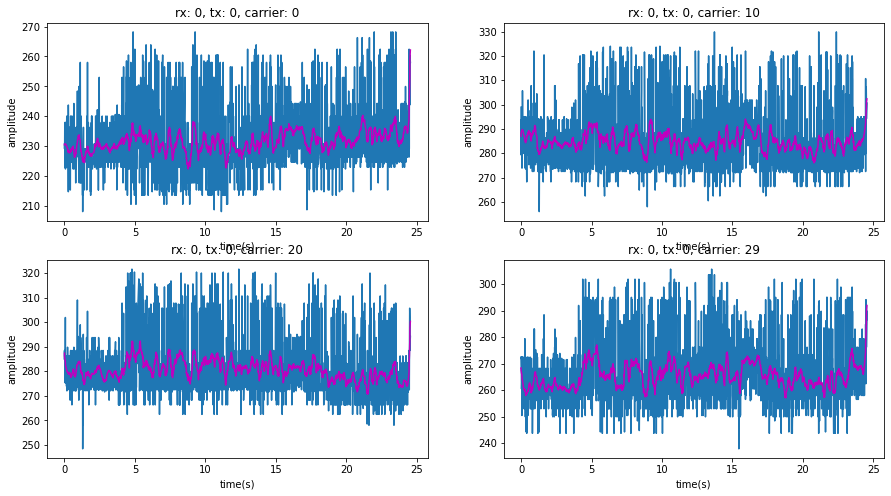

In [35]:
def plot_amplitude_over_time(rx, tx, carrier):
    #if not matplotlib.get_backend().endswith("nbAgg"):
    #    matplotlib.use("nbAgg")
    #f = plt.figure()
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.title(f"rx: {rx}, tx: {tx}, carrier: {carrier}")
    plt.xlabel("time(s)")
    plt.ylabel("amplitude")
    plt.plot(data["csi_timestamps_seconds"], amplitude_signal(rx,tx,carrier))
    plt.plot(data["csi_timestamps_seconds"], savgol_filter(amplitude_signal(rx,tx, carrier), 51, 3), "m")

plt.rcParams['figure.figsize'] = [15, 8]
f = plt.figure()
plt.title("Amplitude over time (respiratory)")
plt.subplot(2,2,1)
plot_amplitude_over_time(0, 0, 0)
plt.subplot(2,2,2)
plot_amplitude_over_time(0, 0, 10)
plt.subplot(2,2,3)
plot_amplitude_over_time(0, 0, 20)
plt.subplot(2,2,4)
plot_amplitude_over_time(0, 0, 29)

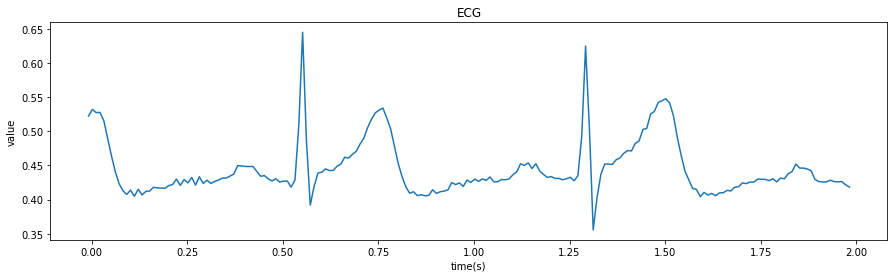

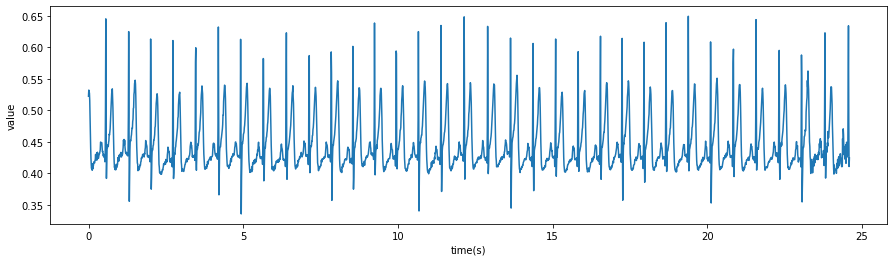

<Figure size 1080x288 with 0 Axes>

In [36]:
plt.rcParams['figure.figsize'] = [15, 4]
plt.title("ECG")
plt.xlabel("time(s)")
plt.ylabel("value")
plt.plot(data["ecg_timestamps_seconds"][0:200], ecg_value_signal()[0:200])
f = plt.figure()
plt.xlabel("time(s)")
plt.ylabel("value")
plt.plot(data["ecg_timestamps_seconds"], ecg_value_signal())

# no need to smooth anything
# plt.plot(ecg_timestamps_seconds, savgol_filter(ecg_signal(), 5, 3))

f = plt.figure()

## Signal sampling
Sample signal at fixed rate so CSI phase and ECG are in sync, as there might be dropped packets in CSI.

In [37]:
def sample_signal(signal, timestamps, sampling_times):
        result_signal = []
        for t in sampling_times:
            closest_index = np.argmin(np.abs(timestamps - t))
            if timestamps[closest_index] > t:
                upper_index = closest_index
                lower_index = closest_index - 1
            else:
                upper_index = closest_index + 1
                lower_index = closest_index
            
            upper_index = min(upper_index, len(timestamps) - 1)
            lower_index = max(lower_index, 0)
            
            # interpolate
            f = (t - timestamps[lower_index]) / (timestamps[upper_index] - timestamps[lower_index])
            interpolated_value = signal[upper_index] * f + signal[lower_index] * (1.0 - f)
            
            result_signal.append(interpolated_value)
        return result_signal

def sample_signals(rx=0, tx=0, subcarrier=25, sampling_freq=100, csi_only=False, use_phase=False):
    if use_phase:
        csi_signal = phase_signal(0, 0, subcarrier)
    else:
        csi_signal = amplitude_signal(0, 0, subcarrier)
    ecg_signal = ecg_value_signal()
    # smoothed_signal = savgol_filter(csi_signal, 51, 3)
    
    sampling_times = np.arange(0, data["csi_total_duration_ms"] / 1000.0, 1.0 / sampling_freq) * 1000.0
    #print(f"Sampling {len(sampling_times)} times, freq: {sampling_freq} Hz, period: {sampling_times[1] - sampling_times[0]} ms")
    
    csi_sampled_signal = sample_signal(csi_signal, data["csi_timestamps_chip"], sampling_times)
    ecg_sampled_signal = None
    if not csi_only:
        ecg_sampled_signal = sample_signal(ecg_signal, data["ecg_timestamps"], sampling_times) 
   

    # Processing
    csi_sampled_signal = savgol_filter(csi_sampled_signal, 51, 3)
    csi_sampled_signal -= np.mean(csi_sampled_signal)
    csi_sampled_signal /= np.std(csi_sampled_signal)
    
    if not csi_only:
        ecg_sampled_signal -= np.mean(ecg_sampled_signal)
        ecg_sampled_signal /= np.std(ecg_sampled_signal)
    
    return csi_sampled_signal, ecg_sampled_signal, sampling_times

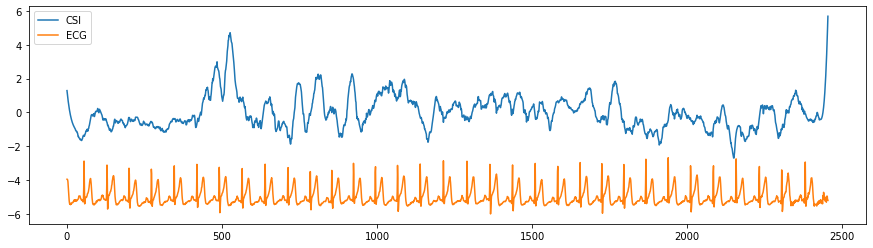

In [38]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 4]
fig = plt.figure()
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25)
plot(csi_sampled_signal, label="CSI")
plot(ecg_sampled_signal / 2 - 5, label="ECG")
plt.legend()

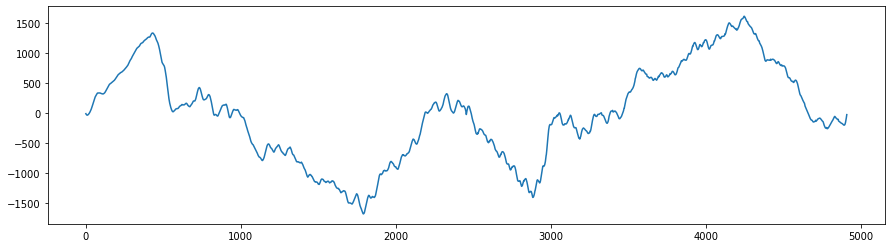

In [39]:
plot(np.correlate(csi_sampled_signal, ecg_sampled_signal / 2 - 5, "full"))

## Peak detection
Detect R waves in ECG to show the individual beats alongside the CSI signal.

DOESN'T DETECT THE PEAKS THEMSELVES! (only filters the signal for peaks, they might not be distinct)

In [40]:
# detect any peak that is significantly above the mean around it (disregards T wave)
def peak_likelihood(signal, freq, peak_neighborhood_time_interval = 0.15):
    squared_signal = signal ** 2 # sqaure to ease detection of peaks and eliminate negative values
    
    peak_neighborhood_interval = round(peak_neighborhood_time_interval * freq / 2)
    
    peak_likelihood = []
    for i in range(len(squared_signal)):
        moving_average = 0
        for j in range(i - peak_neighborhood_interval, i + peak_neighborhood_interval):
            moving_average += squared_signal[max(0, min(len(squared_signal)-1, j))]
        moving_average /= (peak_neighborhood_interval * 2)
        
        peak_likelihood.append(squared_signal[i] / moving_average)
        
    return np.array(peak_likelihood)

def peak_signal(signal, freq, threshold = 5):
    return np.vectorize(lambda v: 1 if v > threshold else 0)(peak_likelihood(signal, freq, ))

In [41]:
%matplotlib auto
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25)
plot(csi_sampled_signal)
plot(peak_signal(ecg_sampled_signal, 100) * 8 - 4)

Using matplotlib backend: TkAgg


## Wavelet transform

In [42]:
%matplotlib inline
import pywt

def wavelet_transform(signal, sampling_times, level = 4, sampling_freq = 100, wavelet = "db4"):
    cAs = []
    cDs = []
    freq_bands = []
    input_signal = signal
    max_freq = sampling_freq / 2.0
    for i in range(level):
        cA, cD = pywt.dwt(input_signal, wavelet)
        cAs.append(cA)
        cDs.append(cD)
    
        # Frequency is only dependent on the sampling rate (due to the wavelet only taking local data into account)
        # The filter only contains the lower/upper half o frequencies        
        freq_bands.append((max_freq/2.0, max_freq))
    
        input_signal = cA # half the resolution
        max_freq /= 2.0
    
    return cAs, cDs, freq_bands


{'intelCsiNotification': {'timestamp_low': -1662972827, 'bfee_count': -93, 'Nrx': 3, 'Ntx': 1, 'rssi_a': 39, 'rssi_b': 3, 'rssi_c': 12, 'noise': -92, 'agc': 16, 'antenna_sel': 24, 'perm': [0, 2, 1], 'len': 192, 'fake_rate_n_flags': 8454}, 'csi_matrix': [[[{'real': -128, 'imag': 192}, {'real': 128, 'imag': 256}, {'real': 288, 'imag': 0}, {'real': 176, 'imag': -240}, {'real': -96, 'imag': -288}, {'real': -288, 'imag': -112}, {'real': -272, 'imag': 96}, {'real': -128, 'imag': 272}, {'real': 112, 'imag': 288}, {'real': 272, 'imag': 128}, {'real': 288, 'imag': -80}, {'real': 160, 'imag': -256}, {'real': -48, 'imag': -272}, {'real': -224, 'imag': -192}, {'real': -272, 'imag': -96}, {'real': -256, 'imag': 128}, {'real': -112, 'imag': 272}, {'real': 80, 'imag': 272}, {'real': 256, 'imag': 144}, {'real': 272, 'imag': -64}, {'real': 176, 'imag': -224}, {'real': -32, 'imag': -288}, {'real': -224, 'imag': -192}, {'real': -304, 'imag': 16}, {'real': -192, 'imag': 240}, {'real': 64, 'imag': 320}, {'

Done
Recording with 2462 ecg entries, 24601 ms loaded


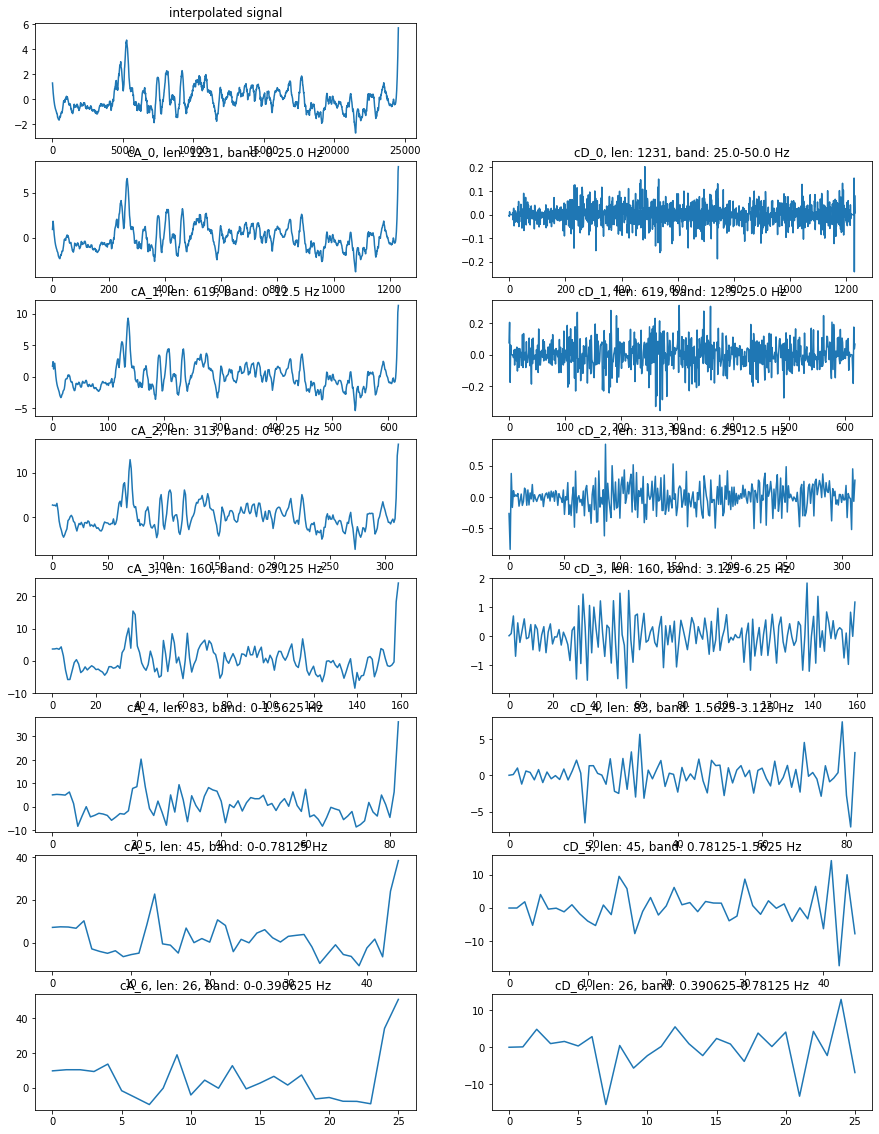

In [43]:
def test_wavelet_transform(use_phase=False):    
    level = 7
    
    if use_phase:
        reload_csi_recording_with_phases(main_scenario_dir)
    else:
        reload_recording(main_scenario_dir)

    csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25, use_phase=use_phase)

    # SINE for frequency testing purposes
    #csi_sampled_signal = np.sin(sampling_times * 2 * np.pi / 1000.0 * 2.0) # TODO: remove, testing
    #csi_sampled_signal = np.where(csi_sampled_signal < 0, 0, csi_sampled_signal)

    cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = level)

    plt.rcParams['figure.figsize'] = [15, 20]
    f = plt.figure()
    plt.subplot(level+1,2,1)
    plt.title("interpolated signal")
    plt.plot(sampling_times, csi_sampled_signal)

    for i in range(level):
        cA = cAs[i] # approximation coefficient
        cD = cDs[i] # detail coefficient
        plt.subplot(level+1,2,3+i*2)
        plt.title(f"cA_{i}, len: {len(cA)}, band: 0-{freq_bands[i][0]} Hz")
        plt.plot(cA)
        plt.subplot(level+1,2,4+i*2)
        plt.title(f"cD_{i}, len: {len(cD)}, band: {freq_bands[i][0]}-{freq_bands[i][1]} Hz")
        plt.plot(cD)

test_wavelet_transform()

## Heart rate signal reconstruction

In [44]:
import scipy.signal as sig

def heart_rate_signal(detailCoefficients, freq_bands, upsample=False):
    hr_signal = np.linspace(0, 0, len(detailCoefficients[len(detailCoefficients)-1]))
    freq_min = 1000
    freq_max = 0
    for i in range(len(detailCoefficients)-1, -1, -1):
        hr_signal = sig.resample(hr_signal, len(detailCoefficients[i]))  # TODO: this uses fourier sampling
        
        if freq_bands[i][1] < 3.5 and freq_bands[i][0] > 0.50:
            freq_min = min(freq_min, freq_bands[i][0])
            freq_max = max(freq_max, freq_bands[i][1])
            hr_signal += detailCoefficients[i]
            
        if freq_bands[i][0] > 2.5 and not upsample:
            break
        
    return hr_signal, (freq_min, freq_max)

Resulting signal is in band 0.78125-3.125 Hz, 46.875-187.5 bpm


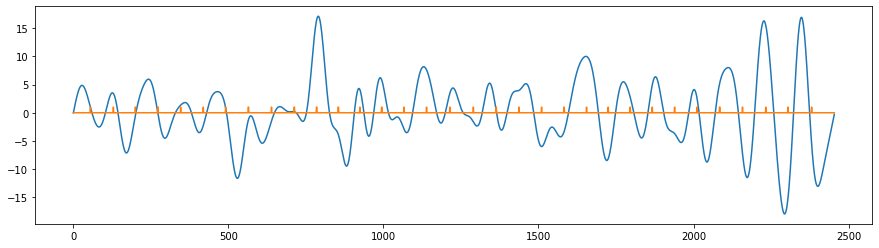

In [45]:
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25)
# csi_sampled_signal = np.sin(sampling_times * 2 * np.pi / 1000.0) # test sine
cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = 7)

csi_hr_signal, freq_band = heart_rate_signal(cDs, freq_bands, upsample=False)

print(f"Resulting signal is in band {freq_band[0]}-{freq_band[1]} Hz, {freq_band[0]*60.0}-{freq_band[1]*60.0} bpm")

plt.rcParams['figure.figsize'] = [15, 4]
plot(sig.resample(csi_hr_signal, len(ecg_sampled_signal)))
plot(peak_signal(ecg_sampled_signal, 100))

## Heart signal reconstruction using inverse DWT

Filtering for selected frequency bands is equal to setting all other detail coefficients and the approx. coefficient to 0 and running a reverse transform.

In [46]:
def heart_rate_signal_idwt(cDs, freq_bands, wavelet='db4'):
    cA = None # pywt will treat None as 0 for the first case
    freq_min = 1000
    freq_max = 0
    
    for i in range(len(cDs)-1, -1, -1):
        cD = None
        
        if freq_bands[i][1] < 3.5 and freq_bands[i][0] > 0.50:
            freq_min = min(freq_min, freq_bands[i][0])
            freq_max = max(freq_max, freq_bands[i][1])
            cD = cDs[i]
        else:
            cD = np.zeros(len(cDs[i]))
        
        if cA is not None and cD is not None:
            cA = sig.resample(cA, len(cD))  # TODO: this uses fourier sampling
        
        #print(f"cA_len: {len(cA) if cA is not None else -1}, cD_len: {len(cD) if cD is not None else -1}")
        cA = pywt.idwt(cA, cD, wavelet)
    
    return cA, (freq_min, freq_max)

Resulting signal is in band 0.78125-3.125 Hz, 46.875-187.5 bpm


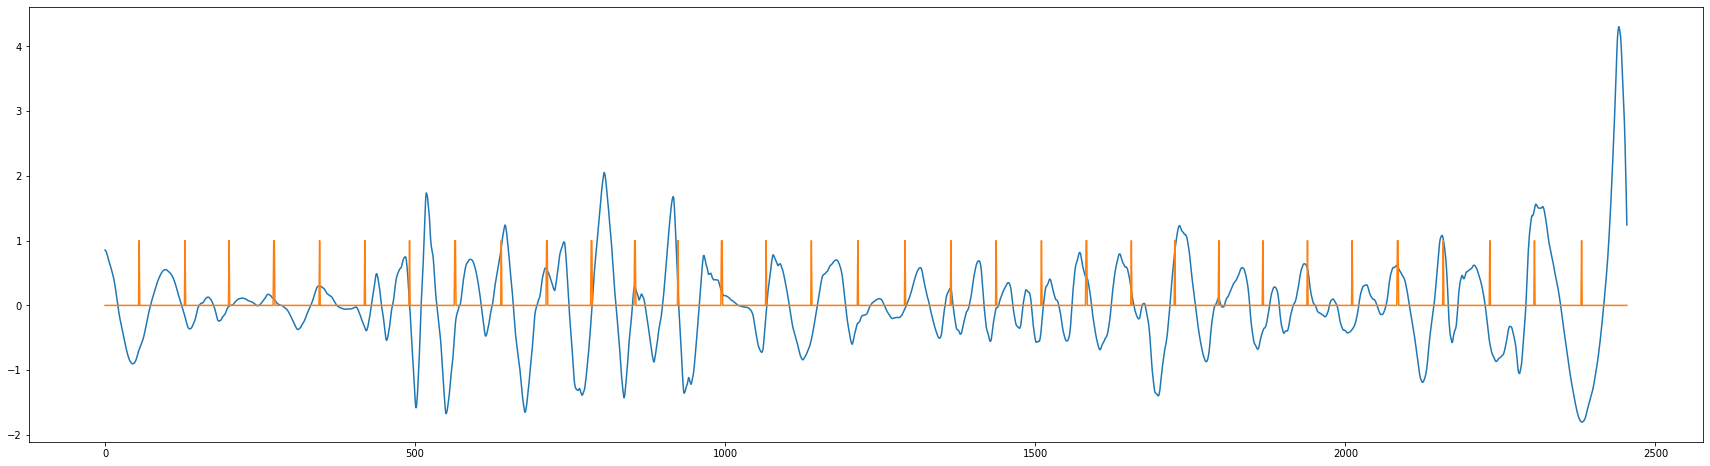

In [47]:
def test_heart_rate_signal_idwt(csi_sampled_signal, ecg_sampled_signal, sampling_times):
    # csi_sampled_signal = np.sin(sampling_times * 2 * np.pi / 1000.0) # test sine
    cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = 7)

    csi_hr_signal, freq_band = heart_rate_signal_idwt(cDs, freq_bands)

    print(f"Resulting signal is in band {freq_band[0]}-{freq_band[1]} Hz, {freq_band[0]*60.0}-{freq_band[1]*60.0} bpm")

    plt.rcParams['figure.figsize'] = [30, 8]
    plot(sig.resample(csi_hr_signal, len(ecg_sampled_signal)))
    plot(peak_signal(ecg_sampled_signal, 100))
    

csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25)
test_heart_rate_signal_idwt(csi_sampled_signal, ecg_sampled_signal, sampling_times)

## Fourier transform

In [48]:
def fourier_transform(signal, sampling_freq):
    bins = fft(signal)
    binSpacing = sampling_freq / 2.0 / (len(bins) / 2.0) # according to nyquist, the FFT can resolve up to sampling_freq/2 frequencies, spread equally accross all bins
    usedBins = floor(len(bins)/2.0)

    magnitudeByBin = [ np.abs(c) for c in bins[1:usedBins]]
    binFrequencies = np.arange(1, usedBins, 1) * binSpacing
    return magnitudeByBin, binFrequencies


Resulting signal is in band 0.78125-3.125 Hz, 46.875-187.5 bpm


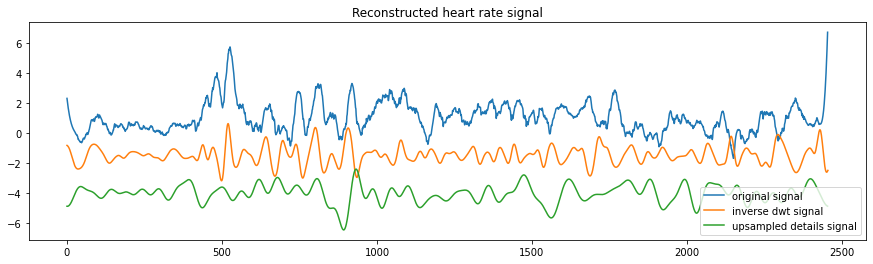

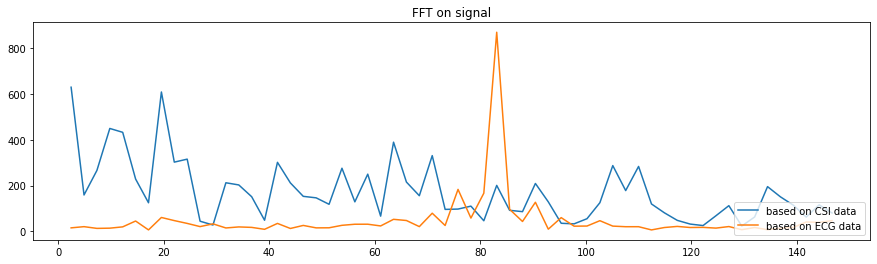

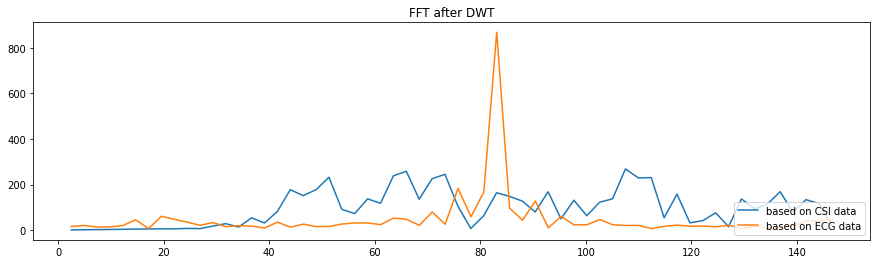

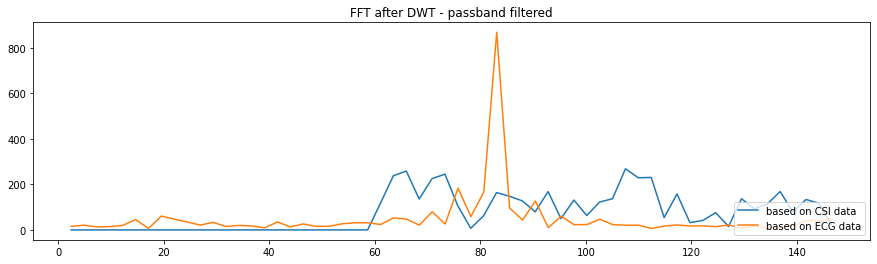

In [50]:
def test_fourier_transform(csi_sampled_signal, ecg_sampled_signal, sampling_times, wavelet):
    cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = 7, wavelet=wavelet)
    csi_hr_signal_upsample, freq_band = heart_rate_signal(cDs, freq_bands, upsample=False)
    print(f"Resulting signal is in band {freq_band[0]}-{freq_band[1]} Hz, {freq_band[0]*60.0}-{freq_band[1]*60.0} bpm")

    csi_hr_signal_inverse, freq_band = heart_rate_signal_idwt(cDs, freq_bands, wavelet=wavelet)

    # Upsample
    csi_hr_signal_upsample = sig.resample(csi_hr_signal_upsample, len(sampling_times))

    # Calculate spectrum
    csi_spectrum, csi_fft_freqs = fourier_transform(csi_hr_signal_inverse, 100)
    ecg_spectrum, ecg_fft_freqs = fourier_transform(ecg_sampled_signal, 100)

    ecg_spectrum = np.array(ecg_spectrum) * 1
    
    # TESTING
    plt.figure()
    plt.title("Reconstructed heart rate signal")
    plot(csi_sampled_signal + 1, label="original signal")
    plot(csi_hr_signal_inverse - 1.5, label="inverse dwt signal")
    plot(csi_hr_signal_upsample / 6 - 4, label="upsampled details signal")
    plt.legend(loc = "lower right")
    # END TESTING

    plt.rcParams['figure.figsize'] = [15, 4]
    # original signal
    fig = plt.figure()
    plt.title("FFT on signal")
    non_wavelet_csi_spectrum, non_wavelet_csi_fft_freqs = fourier_transform(csi_sampled_signal, 100)
    plot(non_wavelet_csi_fft_freqs[0:60] * 60, non_wavelet_csi_spectrum[0:60], label="based on CSI data")
    plot(ecg_fft_freqs[0:60] * 60, ecg_spectrum[0:60], label="based on ECG data")
    plt.legend(loc = "lower right")

    fig = plt.figure()
    plt.title("FFT after DWT")
    plot(csi_fft_freqs[0:60] * 60, csi_spectrum[0:60], label="based on CSI data")
    plot(ecg_fft_freqs[0:60] * 60, ecg_spectrum[0:60], label="based on ECG data")
    plt.legend(loc = "lower right")

    passband_filtered = np.where(csi_fft_freqs > 60/60, csi_spectrum, 0)
    fig = plt.figure()
    plt.title("FFT after DWT - passband filtered")
    plot(csi_fft_freqs[0:60] * 60, passband_filtered[0:60], label="based on CSI data")
    plot(ecg_fft_freqs[0:60] * 60, ecg_spectrum[0:60], label="based on ECG data")
    plt.legend(loc = "lower right")
    

csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25)
#csi_sampled_signal = np.sin(sampling_times * 2 * np.pi / 1000.0 * 1) # TODO: remove, testing
#csi_sampled_signal = np.sin(sampling_times * 2 * np.pi / 1000.0 * 1.0) # TODO: remove, testing
#csi_sampled_signal = np.where(csi_sampled_signal < 0, 0, csi_sampled_signal)
wavelet = 'sym10'

test_fourier_transform(csi_sampled_signal, ecg_sampled_signal, sampling_times, wavelet)

#### Wavelet comparison

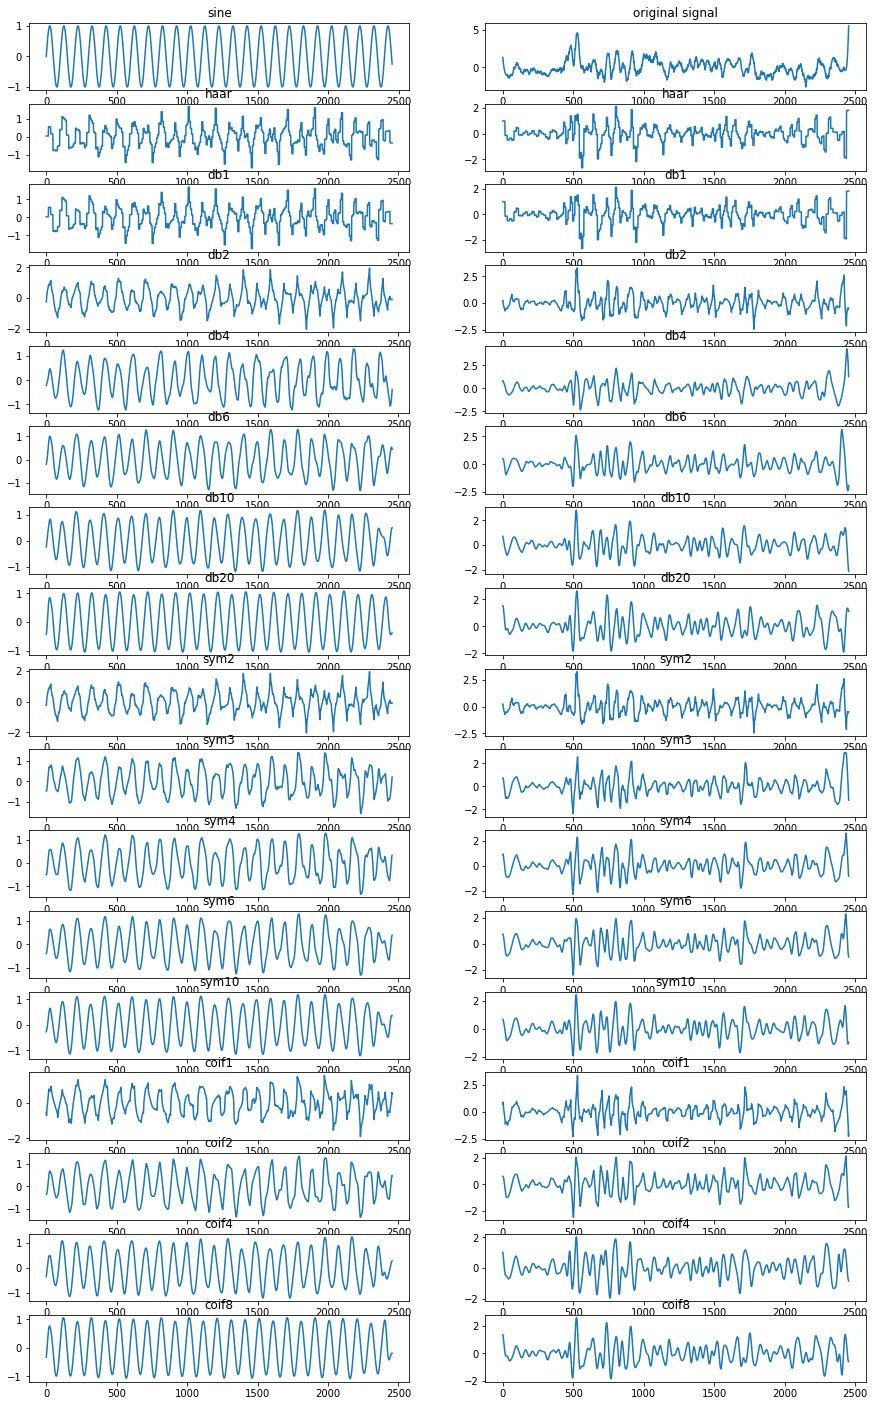

In [26]:
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25) # Actual signal
sine_signal = np.sin(sampling_times * 2 * np.pi / 1000.0 * 1) # SINE

wavelets = [ 'haar', 'db1', 'db2', 'db4', 'db6', 'db10', 'db20',
           'sym2', 'sym3','sym4','sym6','sym10',
           'coif1','coif2','coif4','coif8']

plt.rcParams['figure.figsize'] = [15, 25]
plt.figure()
plt.subplot(len(wavelets)+1, 2, 1)
plot(sine_signal)
plt.title("sine")
plt.subplot(len(wavelets)+1, 2, 2)
plt.title("original signal")
plot(csi_sampled_signal)

for i in range(len(wavelets)):
    wavelet = wavelets[i]
    cAs, cDs, freq_bands = wavelet_transform(sine_signal, sampling_times, level = 7, wavelet=wavelet)
    csi_hr_signal_inverse, freq_band = heart_rate_signal_idwt(cDs, freq_bands, wavelet=wavelet)
    
    plt.subplot(len(wavelets)+1, 2, i*2 + 3)
    plt.title(wavelet)
    plot(csi_hr_signal_inverse)
    
    cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = 7, wavelet=wavelet)
    csi_hr_signal_inverse, freq_band = heart_rate_signal_idwt(cDs, freq_bands, wavelet=wavelet)
    
    plt.subplot(len(wavelets)+1, 2, i*2 + 4)
    plt.title(wavelet)
    plot(csi_hr_signal_inverse)

In [27]:
filtered_hr_signal = ifft(passband_filtered)
filtered_hr_signal = filtered_hr_signal[0:round(len(filtered_hr_signal) / 2)]
filtered_hr_signal = sig.resample(filtered_hr_signal, len(sampling_times))

plt.rcParams['figure.figsize'] = [15, 3]
plot(filtered_hr_signal)
plot(peak_signal(ecg_sampled_signal, 100) - 4)

NameError: name 'passband_filtered' is not defined

## Subcarriers overview
Testing different subcarriers

NameError: name 'cA' is not defined

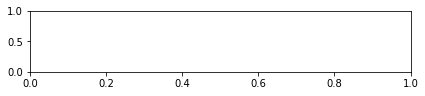

In [28]:
plt.rcParams['figure.figsize'] = [15, 20]
f = plt.figure()

def get_avg_spectrum(subcarriers, enable_plot=False, wavelet='db6', use_phase=False):
    spectrums_sum = None
    fft_freqs = None
    ecg_spectrum = None
    ecg_fft_freqs = None
    carriers_summed = 0
    for i in subcarriers:
        csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, i, csi_only=(i != 0), use_phase=use_phase)
        cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = 7, wavelet=wavelet)
        csi_hr_signal, freq_band = heart_rate_signal_idwt(cDs, freq_bands, wavelet=wavelet)
    
        # Upsample
        csi_hr_signal = sig.resample(csi_hr_signal, len(sampling_times))

        csi_spectrum, csi_fft_freqs = fourier_transform(csi_hr_signal, 100)
        #csi_spectrum = np.array(csi_spectrum) ** 2
        csi_spectrum = np.array(csi_spectrum) / np.amax(csi_spectrum)
    
        if i == 0:
            ecg_spectrum, ecg_fft_freqs = fourier_transform(ecg_sampled_signal, 100)
            #ecg_spectrum = np.array(ecg_spectrum) * 1
            ecg_spectrum /= np.amax(ecg_spectrum) * 2
        
        passband_filtered = np.where(csi_fft_freqs > 60/60, csi_spectrum, 0)
        
        if enable_plot:
            max_index = len(list(filter(lambda f: f < 2.0, csi_fft_freqs)))
            plt.subplot(15,2,round((i)+1))
            plt.title(f"cA_{i}, len: {len(cA)}")
            #plot(csi_fft_freqs[0:60] * 60, csi_spectrum[0:60])
            #plot(ecg_fft_freqs[0:60] * 60, ecg_spectrum[0:60])
            plot(csi_fft_freqs[0:max_index] * 60, passband_filtered[0:max_index])
            plot(ecg_fft_freqs[0:max_index] * 60, ecg_spectrum[0:max_index])
    
        # sum up for average over all subcarriers
        spectrums_sum = passband_filtered if i == 0 else spectrums_sum + passband_filtered
        fft_freqs = csi_fft_freqs
        carriers_summed += 1
    
    avg_spectrum = spectrums_sum / carriers_summed
    avg_spectrum /= np.amax(avg_spectrum) # Normalize
    
    return avg_spectrum, fft_freqs, ecg_spectrum, ecg_fft_freqs


avg_spectrum, fft_freqs, ecg_spectrum, ecg_fft_freqs = get_avg_spectrum(range(0, 30, 1), enable_plot=True)

# sum of all signals
plt.rcParams['figure.figsize'] = [15, 4]
f = plt.figure()

def get_avg_freq(spectrum, fft_freqs):
    avg_freq = 0
    weight_sum = 0
    for i in range(60):
        weight_sum += spectrum[i]
        avg_freq += (fft_freqs[i] * 60) * spectrum[i]
    avg_freq /= weight_sum
    return avg_freq

avg_freq = get_avg_freq(avg_spectrum, fft_freqs)

def plot_avg_signal(avg_spectrum, ecg_spectrum, fft_freqs, avg_freq):
    max_index = len(list(filter(lambda f: f < 2.0, fft_freqs)))
    plot(fft_freqs[0:max_index] * 60, avg_spectrum[0:max_index])
    plot(fft_freqs[0:max_index] * 60, ecg_spectrum[0:max_index])
    plt.vlines(avg_freq, np.amin(avg_spectrum), np.amax(avg_spectrum), colors=['green'])
    
plot_avg_signal(avg_spectrum, ecg_spectrum, fft_freqs, avg_freq)
print(f"Average freq: {avg_freq} Hz")

## Scenarios overview
Testing different scenarios

In [ ]:
def test_scenarios(wavelet, use_phase=False):
    plt.rcParams['figure.figsize'] = [15, 20]
    f = plt.figure()

    for scenario in all_scenarios:
        scenario_name = scenario.split("_2020")[0].split("both-2020-12-15/")[1]
        reload_recording(scenario)
        print("SCENARIO: ", scenario_name)

        avg_spectrum, fft_freqs, ecg_spectrum, ecg_fft_freqs = get_avg_spectrum(range(0, 30, 5), enable_plot=False, wavelet=wavelet, use_phase=use_phase)

        avg_freq = get_avg_freq(avg_spectrum, fft_freqs)    

        plt.subplot(len(all_scenarios), 1, all_scenarios.index(scenario) + 1)
        plt.title(scenario_name)
        plot_avg_signal(avg_spectrum, ecg_spectrum, fft_freqs, avg_freq)

        print("\n")

wavelet = 'sym10'
test_scenarios(wavelet)

## Derivative of signal

In [ ]:
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25)
cAs, cDs, freq_bands = wavelet_transform(csi_sampled_signal, sampling_times, level = 7)

csi_hr_signal, freq_band = heart_rate_signal(cDs, freq_bands, upsample=False)

print(f"Resulting signal is in band {freq_band[0]}-{freq_band[1]} Hz, {freq_band[0]*60.0}-{freq_band[1]*60.0} bpm")

plt.rcParams['figure.figsize'] = [15, 4]
plot(np.gradient(sig.resample(csi_hr_signal, len(ecg_sampled_signal))))
plot(peak_signal(ecg_sampled_signal, 100)*0.1)







<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>


# Phase analysis

## Data loading

In [31]:
def reload_csi_recording_with_phases(scenario_dir):
    reload_recording(scenario_dir)
    
    print("Converting phases...")
    csi_complex = data["csi_complex"]
    csi_phases_uncorrected = [[[[np.angle(c) for c in tx] for tx in rx] for rx in packet] for packet in csi_complex]
    csi_phases_uncorrected = np.array(csi_phases_uncorrected)
    
    # correct phase
    csi_phases = np.copy(csi_phases_uncorrected)
    for packet in csi_phases:
        for rx in packet:
            for tx in rx:
                for i in range(30):
                    tx[i] = tx[i] + i * ((4.0 * 2.0 * np.pi) / 30.0)
                    tx[i] = (tx[i] + np.pi) % (2 * np.pi) - np.pi
                    if i >= 1 and tx[i] - tx[i-1] > np.pi:
                        tx[i] = tx[i] - 2*np.pi
                    if i >= 1 and tx[i-1] - tx[i] > np.pi:
                        tx[i] = tx[i] + 2*np.pi

    # unwrap phase data
    #csi_phases_unwrapped = np.copy(csi_phases)
    #for packet in csi_phases_unwrapped:
    #    for rx in packet:
    #        for tx in rx:
    #            for i in range(30):
    #                if i >= 1 and tx[i] - tx[i-1] > np.pi:
    #                    tx[i] = tx[i] - 2*np.pi
    #                if i >= 1 and tx[i-1] - tx[i] > np.pi:
    #                    tx[i] = tx[i] + 2*np.pi
    
    data["csi_phases"] = csi_phases
    
    print("Done")

    
reload_csi_recording_with_phases(main_scenario_dir)

Recording with 2701 csi entries, 24542 ms loaded
Converting...
Done
Recording with 2462 ecg entries, 24601 ms loaded
Converting phases...
Done


In [32]:
def phase_signal(rx, tx, carrier):
    return data["csi_phases"][:,rx,tx,carrier]



## Sampling

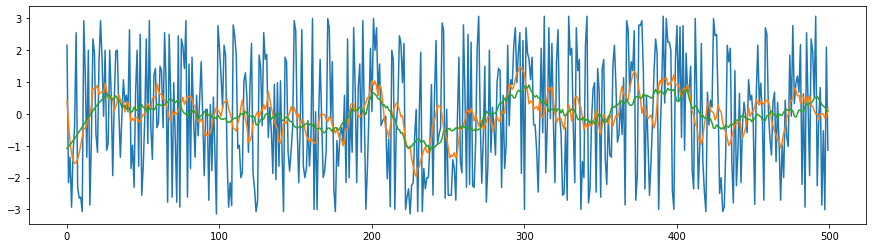

In [33]:
from scipy.signal import savgol_filter

interval_sample_length = 500

plt.rcParams['figure.figsize'] = [15, 4]
plot(phase_signal(0, 0, 0)[0:interval_sample_length])
plot(savgol_filter(phase_signal(0,0,0), 21, 3)[0:interval_sample_length])
plot(savgol_filter(phase_signal(0,0,0), 51, 3)[0:interval_sample_length])

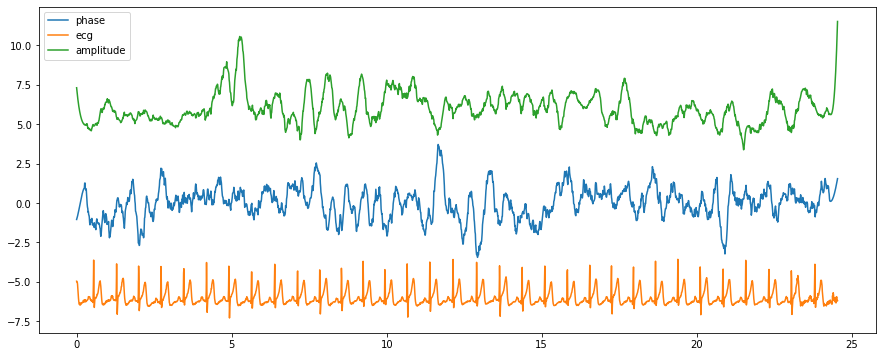

In [34]:
#window_length_seconds = 0.1
#window_length_samples = 

csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25, use_phase=True)
csi_sampled_signal_amplitude, _, _ = sample_signals(0, 0, 25, use_phase=False)

sampling_times_s = sampling_times / 1000
plt.rcParams['figure.figsize'] = [15, 6]
plot(sampling_times_s, csi_sampled_signal, label="phase")
plot(sampling_times_s, ecg_sampled_signal / 2 - 6, label="ecg")
plot(sampling_times_s, csi_sampled_signal_amplitude + 6, label="amplitude")
plt.legend()

## Wavelet transform

Recording with 2701 csi entries, 24542 ms loaded
Converting...
Done
Recording with 2462 ecg entries, 24601 ms loaded
Converting phases...
Done


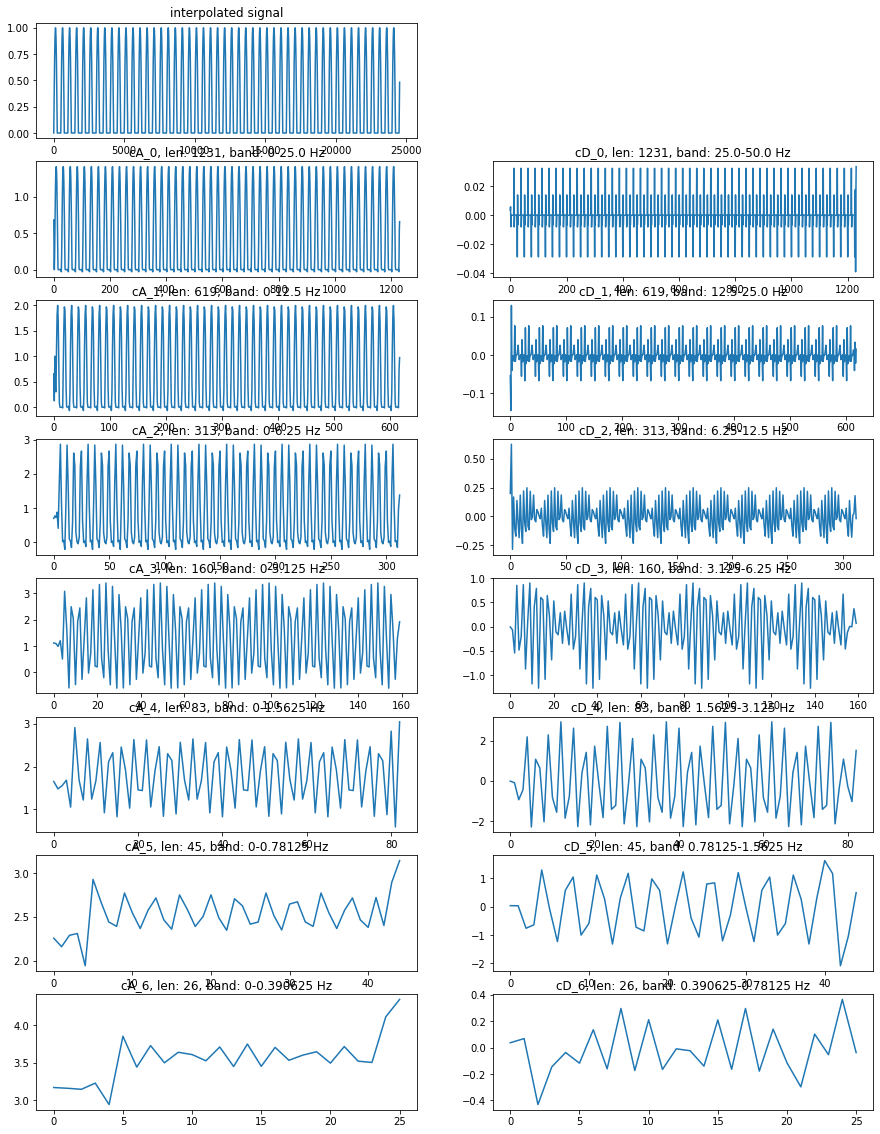

In [35]:
test_wavelet_transform(use_phase=True)

## Heart rate signal reconstruction

Resulting signal is in band 0.78125-3.125 Hz, 46.875-187.5 bpm


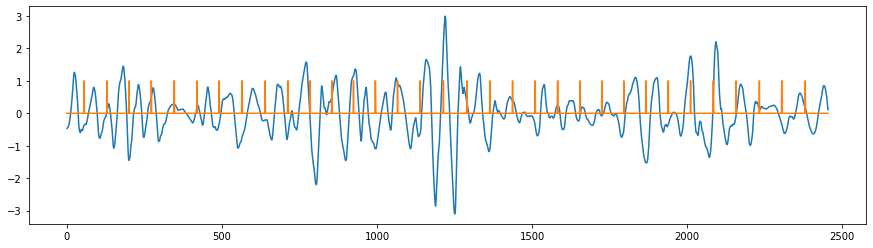

In [36]:
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25, use_phase=True)
test_heart_rate_signal_idwt(csi_sampled_signal, ecg_sampled_signal, sampling_times)

## Fourier transform

Resulting signal is in band 0.78125-3.125 Hz, 46.875-187.5 bpm


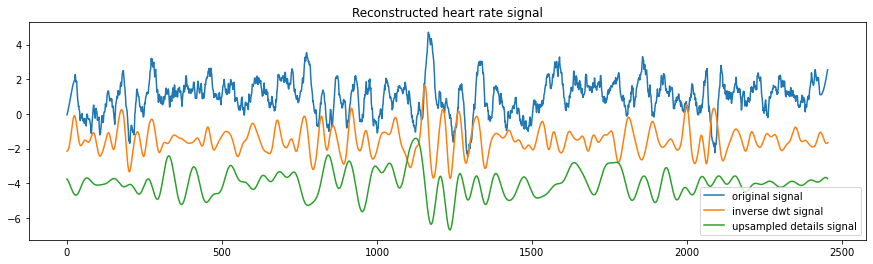

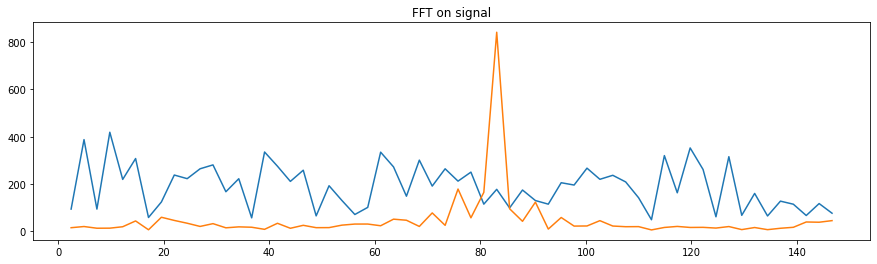

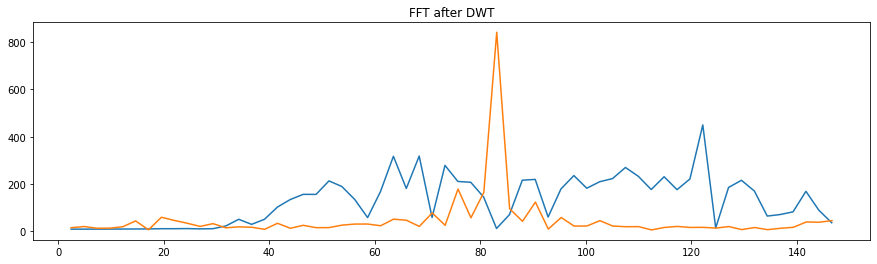

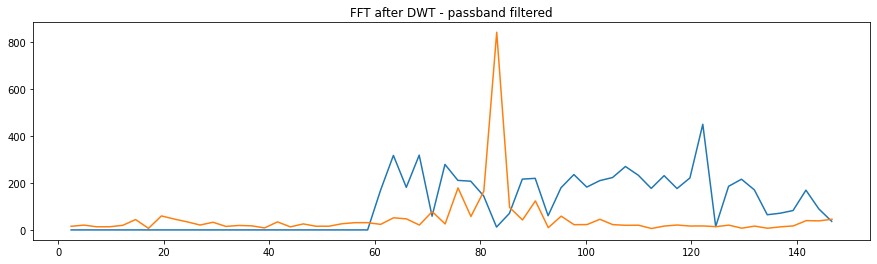

In [37]:
wavelet = 'sym10'
csi_sampled_signal, ecg_sampled_signal, sampling_times = sample_signals(0, 0, 25, use_phase=True)


test_fourier_transform(csi_sampled_signal, ecg_sampled_signal, sampling_times, wavelet)

## Subcarrier comparison

NameError: name 'cA' is not defined

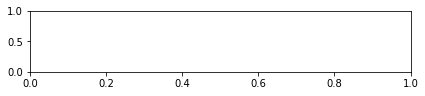

In [38]:
wavelet = 'db4'
plt.rcParams['figure.figsize'] = [15, 20]
avg_spectrum, fft_freqs, ecg_spectrum, ecg_fft_freqs = get_avg_spectrum(range(0, 30, 1), wavelet=wavelet, enable_plot=True, use_phase=True)

# sum of all signals
plt.rcParams['figure.figsize'] = [15, 4]
f = plt.figure()

avg_freq = get_avg_freq(avg_spectrum, fft_freqs)
    
plot_avg_signal(avg_spectrum, ecg_spectrum, fft_freqs, avg_freq)
print(f"Average freq: {avg_freq} Hz")

In [ ]:
def test_scenarios(wavelet, use_phase=False):
    plt.rcParams['figure.figsize'] = [15, 20]
    f = plt.figure()

    for scenario in all_scenarios:
        scenario_name = scenario.split("_2020")[0].split("both-2020-12-15/")[1]
        reload_recording(scenario)
        print("SCENARIO: ", scenario_name)

        avg_spectrum, fft_freqs, ecg_spectrum, ecg_fft_freqs = get_avg_spectrum(range(0, 30, 5), enable_plot=False, wavelet=wavelet, use_phase=use_phase)

        avg_freq = get_avg_freq(avg_spectrum, fft_freqs)    

        plt.subplot(len(all_scenarios), 1, all_scenarios.index(scenario) + 1)
        plt.title(scenario_name)
        plot_avg_signal(avg_spectrum, ecg_spectrum, fft_freqs, avg_freq)

        print("\n")

wavelet = 'db4'
test_scenarios(wavelet, use_phase=True)